## Finding excited states using the variational method

Emmy Blumenthal 10/19

In [1]:
using LinearAlgebra, Latexify

ħ = 1;
m = 1;

nPts=200
Δx = 1/(nPts-1)
x=collect((-1/2):Δx:(1/2));
∇² =Δx^(-2)*SymTridiagonal(-2ones(nPts),ones(nPts-1));
V = Diagonal(vcat(1e8,zeros(nPts-2),1e8));
H = (-ħ^2/(2m))∇² + V

200×200 SymTridiagonal{Float64, Vector{Float64}}:
      1.0004e8  -19800.5        ⋅   …        ⋅         ⋅         ⋅ 
 -19800.5        39601.0  -19800.5           ⋅         ⋅         ⋅ 
       ⋅        -19800.5   39601.0           ⋅         ⋅         ⋅ 
       ⋅              ⋅   -19800.5           ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅   …        ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅   …        ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
       ⋅              ⋅         ⋅            ⋅         ⋅         ⋅ 
      ⋮                             ⋱                      
      

We define the potential to be zero everywhere except at $x = \pm \frac{1}{2}$, where it blows up to $10^{10}$. This is how we enforce boundary conditions.

Our ansatz is $\psi \propto A_1 \sin(k_1 x) + A_2 \cos(k_2 x)$

In [2]:
function ψ(params)
    k₁, k₂, A₁, A₂ = params
    ψNotNormalized = A₁ .* sin.(k₁.*x) .+ A₂ .* cos.(k₂.*x)
    return ψNotNormalized / (sqrt(Δx)*norm(ψNotNormalized))
end

Efunc(params) = Δx * ψ(params)' * H * ψ(params)

Efunc (generic function with 1 method)

Variational parameters for the ground state:

In [3]:
using Optim

gsResults = optimize(Efunc,[1.,1.,1.,1.]);  #optimize Efunc. second argument is initial guess

ψgsParams = Optim.minimizer(gsResults) #get parameters
ψ₀ = ψ(ψgsParams) #get variational wave-function
latexify("k_1 ="*string(round(ψgsParams[1],digits=2))) |> display
latexify("k_2 ="*string(round(ψgsParams[2],digits=2))) |> display
latexify("A ="*string(round(ψgsParams[3],digits=2))) |> display
latexify("B ="*string(round(ψgsParams[4],digits=2))) |> display
latexify("E_0 ="*string(round(Efunc(ψgsParams),digits=2))) |> display

L"$k_{1} = -0.0$"

L"$k_{2} = 3.14$"

L"$A = -0.94$"

L"$B = 1.94$"

L"$E_{0} = 4.93$"

The actual ground state energy is $E_n = \frac{\hbar^2 n^2 \pi^2}{2 m L^2}$, so if we chose the right ansatz, $E_0$ should be $\pi^2 / 2 = 4.93$. So we achieved the correct ground state energy using our variational method!

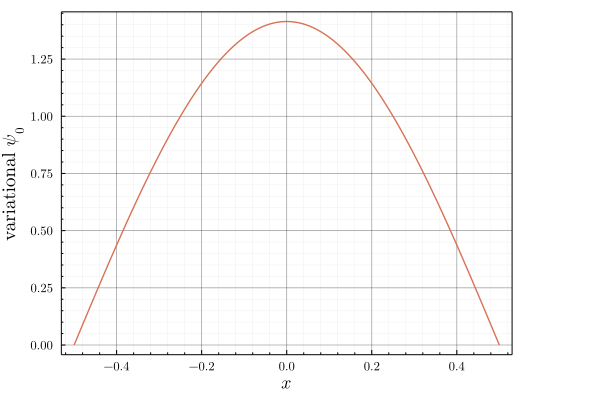

In [4]:
using Plots, LaTeXStrings
theme(:dao)

plot(x,ψ₀,label=:none)
plot!(xlabel=L"x",ylabel=L"variational $\psi_0$")

### A reminder on constrained optimization:

If the problem we're trying to solve is,
$$
\min_{x_i} \; f(x_i)
\qquad \text{s.t.} \quad c(x_i) = 0,
$$
we can instead solve the Lagrange dual problem by defining $L(x_i,\lambda) = f(x_i) - \lambda c(x_i)$ and solving,
$$
% \max_{\lambda} 
% \;
g(\lambda) =
\min_{x_i}
L(x_i,\lambda),
$$
and
$$
\max_\lambda \; g(\lambda) \qquad \text{s.t.}\;\lambda \geq 0,
$$
which is really two nested problems.
We recover the minimizer by solving $\lambda^\star$ that satisfies the maximization problem and finding $\argmin_{x_i} L(x_i,\lambda^\star)$.
For more, see the Wikipedia page: https://en.wikipedia.org/wiki/Lagrange_multiplier.


To find the first excited state, we want to find a state that is orthogonal to the ground state (remember the energy eigenstates form an orthonormal basis), so we want to solve the optimization problem:
$$
\min_{k_1,k_2,A,B}
\;
\left\langle\psi_{k_1,k_2,A,B}\middle|\hat H\middle| \psi_{k_1,k_2,A,B}\right\rangle
\qquad
\text{s.t.} \quad \left\langle\psi_{k_1,k_2,A,B}\middle|\psi_{0}\right\rangle = 0
$$

In [5]:
L(params,λ::Float64) = Efunc(params) + abs(λ * (ψ₀' * ψ(params))*Δx)
g(λ::Float64) = Optim.minimum(optimize(params -> L(params,λ),[1.0,1.0,1.0,1.0]))
λsol = Optim.minimizer(optimize(λ -> -g(λ[1]),[1e8]))[1]
ψ1params = Optim.minimizer(optimize(params -> L(params,λsol),[1.0,1.0,1.0,1.0]))
ψ₁ = ψ(ψ1params)
latexify("k_1 ="*string(round(ψ1params[1],digits=2))) |> display
latexify("k_2 ="*string(round(ψ1params[2],digits=2))) |> display
latexify("A ="*string(round(ψ1params[3],digits=2))) |> display
latexify("B ="*string(round(ψ1params[4],digits=2))) |> display
latexify("E_1 ="*string(round(Efunc(ψ1params),digits=2))) |> display

L"$k_{1} = 6.28$"

L"$k_{2} = -26.27$"

L"$A = 44.1$"

L"$B = -0.0$"

L"$E_{1} = 19.74$"

The first excited state should have energy $E_1 = 2^2 \pi^2/2 = 19.74$. We got the energy of the first excited state! Nice!

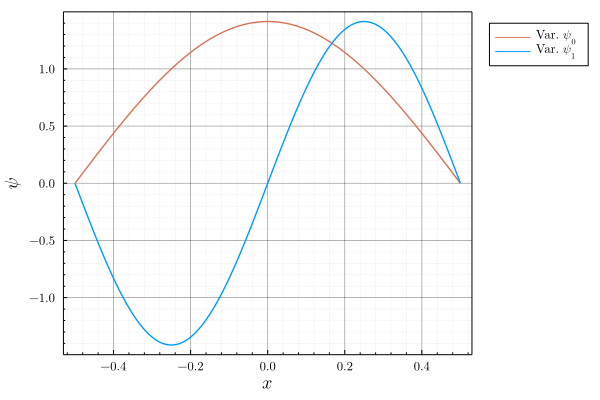

In [6]:
plot(x,ψ₀,label=L"Var. $\psi_0$")
plot!(x,ψ₁,label=L"Var. $\psi_1$")
plot!(xlabel=L"x",ylabel=L"\psi")

These variational wave functions match the analytic results we're familiar with!

In order to find higher excited states, we would need to use multiple Lagrange multipliers: